In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
import cv2
import itertools

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# Define paths
train_image_dir = '/kaggle/input/wound-segmentation-images/data_wound_seg/train_images'
train_mask_dir = '/kaggle/input/wound-segmentation-images/data_wound_seg/train_masks'
test_image_dir = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_images'
test_mask_dir = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_masks'
correspondence_table_path = '/kaggle/input/wound-segmentation-images/data_wound_seg/correspondence_table.xlsx'

# Get list of image and mask files
train_images = sorted(glob(os.path.join(train_image_dir, '*.png')))
train_masks = sorted(glob(os.path.join(train_mask_dir, '*.png')))
test_images = sorted(glob(os.path.join(test_image_dir, '*.png')))
test_masks = sorted(glob(os.path.join(test_mask_dir, '*.png')))

print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of testing masks: {len(test_masks)}")

Number of training images: 2208
Number of training masks: 2208
Number of testing images: 552
Number of testing masks: 552


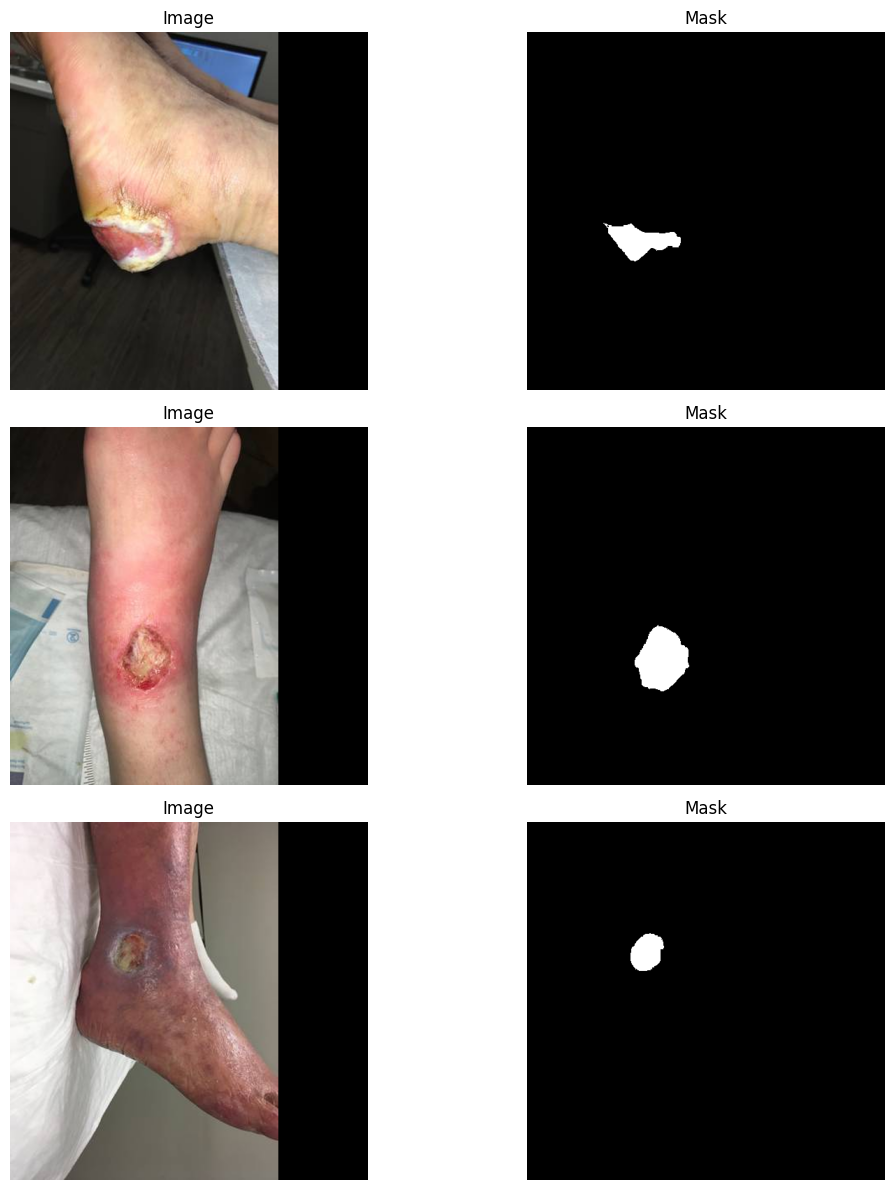

In [3]:
def display_samples(images, masks, num=5):
    plt.figure(figsize=(12, num * 4))
    for i in range(num):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)

        plt.subplot(num, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 3 samples from the training set
display_samples(train_images, train_masks, num=3)

In [4]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16

# Updated Data Generator with float32 casting
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, img_height, img_width, augment=False):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for i, m in zip(batch_x, batch_y):
            # Read and preprocess image
            img = cv2.imread(i)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_width, self.img_height))
            img = img / 255.0  # Normalize
            img = img.astype(np.float32)  # Cast to float32

            # Read and preprocess mask
            mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_width, self.img_height))
            mask = np.expand_dims(mask, axis=-1)
            mask = mask / 255.0  # Normalize
            mask = mask.astype(np.float32)  # Cast to float32

            if self.augment:
                # Random horizontal flip
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)

                # Random vertical flip
                if np.random.rand() > 0.5:
                    img = np.flipud(img)
                    mask = np.flipud(mask)

                # Random rotation
                angle = np.random.randint(-15, 15)
                M = cv2.getRotationMatrix2D((self.img_width/2, self.img_height/2), angle, 1)
                img = cv2.warpAffine(img, M, (self.img_width, self.img_height)).astype(np.float32)
                mask = cv2.warpAffine(mask, M, (self.img_width, self.img_height)).astype(np.float32)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create generators
train_generator = DataGenerator(train_images, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, augment=True)
test_generator = DataGenerator(test_images, test_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

In [5]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bridge
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model
model = unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [6]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [7]:
# Compile the model with additional metrics
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou_metric])

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Updated Callbacks with .keras extension
checkpoint = ModelCheckpoint('unet_wound_segmentation_best.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss', 
                          patience=5, 
                          verbose=1, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              verbose=1, 
                              mode='min', 
                              min_lr=1e-6)

callbacks_list = [checkpoint, earlystop, reduce_lr]

# Compile the model with updated metrics
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou_metric])

# Training the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25, 
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9745 - dice_coefficient: 0.6091 - iou_metric: 0.4458 - loss: 0.0582
Epoch 1: val_loss improved from inf to 0.01669, saving model to unet_wound_segmentation_best.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 155s 943ms/step - accuracy: 0.9745 - dice_coefficient: 0.6092 - iou_metric: 0.4459 - loss: 0.0582 - val_accuracy: 0.9936 - val_dice_coefficient: 0.6548 - val_iou_metric: 0.4906 - val_loss: 0.0167 - learning_rate: 1.0000e-04
Epoch 2/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9768 - dice_coefficient: 0.6481 - iou_metric: 0.4870 - loss: 0.0514
Epoch 2: val_loss did not improve from 0.01669
138/138 ━━━━━━━━━━━━━━━━━━━━ 127s 907ms/step - accuracy: 0.9768 - dice_coefficient: 0.6481 - iou_metric: 0.4870 - loss: 0.0513 - val_accuracy: 0.9925 - val_dice_coefficient: 0.5981 - val_iou_metric: 0.4310 - val_loss: 0.0184 - learning_rate: 1.0000e-04
Epoch 3/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9777 - d

In [10]:
# Save the model in .h5 format
model.save('unet_wound_segmentation.h5')
print("Model saved as unet_wound_segmentation.h5")

Model saved as unet_wound_segmentation.h5


In [11]:
# Save the model in the Kaggle working directory
model_path = '/kaggle/working/unet_wound_segmentation.h5'
model.save(model_path)
print(f"Model saved at {model_path}")


Model saved at /kaggle/working/unet_wound_segmentation.h5
